In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)

PROCESSING IMAGES

In [2]:
labels = ("glioma", "meningioma", "notumor", "pituitary")
img_dim = (512, 512)

In [3]:
import numpy as np
import os
import cv2

def load_images_dataset(label, num_images, kernal_size, img_dim):
    root = os.path.join(os.getcwd(), 'data') # get system path to data folder
    path = os.path.join(root, label) # get path to label folder
    file_paths = os.listdir(path) # list all files

    random_select = np.random.choice(file_paths, num_images, replace=False) # get N random selection of files
    images = []
    for f in random_select:                                                 # Preprocess images
        img_path = os.path.join(path, f)                                    # Get full file path
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)                    # Read image as grayscale
        img = cv2.resize(img, img_dim, interpolation=cv2.INTER_LINEAR)      # Resize image to correct dimensions
        ksize = (kernal_size, kernal_size)
        blur = cv2.blur(img, ksize)                                         # Blur image with square kernel size given
        normalized_img = cv2.normalize(blur, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)    # normalize image
        images.append(normalized_img)

    return images

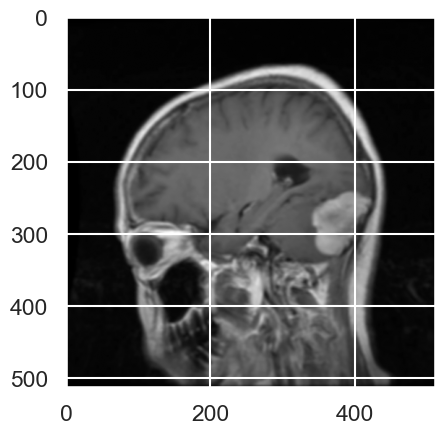

In [4]:
images = load_images_dataset('glioma', 200, 5, img_dim)
plt.imshow(images[1], cmap='gray')

In [5]:
def convert_images_to_np_array(img_list):
    size = len(img_list)
    num_col = img_list[0].shape[0] * img_list[0].shape[1]   # get number of cols by multiplying dims of first image, all same dim

    for i in range(size):
        img_list[i] =  np.ndarray.flatten(img_list[i]).reshape(num_col, 1)      # flatten image

    img_stack = np.dstack(img_list)                                             # Remove extra axis
    img_stack = np.rollaxis(img_stack, axis = 2, start = 0)
    img_stack = img_stack.reshape(size, num_col)

    return img_stack


In [6]:
from sklearn.utils import shuffle
def create_dataframe(num_images, kernal_size, img_dim):

    df_list = []

    for l in labels:    # for each label
        temp_list = load_images_dataset(l, num_images, kernal_size, img_dim)    # load images
        temp_array = convert_images_to_np_array(temp_list)                      # convert images to np arraies
        temp_df = pd.DataFrame(temp_array)                                      # convert each array to a df
        temp_df['label'] = l                                                    # add corresponding label to group of images
        df_list.append(temp_df)

    act = pd.concat(df_list, ignore_index=True)         # combine dataframes into one
    final = shuffle(act).reset_index()                  # shuffle images
    final = final.drop(columns=['index'], axis=1)       # drop unneeded index col

    return final

In [7]:
df = create_dataframe(num_images=200, kernal_size=5, img_dim=img_dim)
print(df.shape)
df.head()
df.tail()

(800, 262145)


,0,1,2,3,4,5,6,7,8,9,...,262135,262136,262137,262138,262139,262140,262141,262142,262143,label
795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,glioma
796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,glioma
797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,pituitary
798,2,2,2,2,1,1,1,1,1,2,...,2,2,2,1,1,1,1,1,1,meningioma
799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,meningioma


In [7]:
def split_x_and_y(df):

    x = df.iloc[:, :-1] # get image data from data frame
    y = df.iloc[:, -1]  # get label data from data frame

    return (x, y)

SUPERVISED LEARNING MODEL

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

def multiclass_logistic_regression(solver, test_size, random_state, df):

    x, y = split_x_and_y(df)    # split the image data from the labels

    x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=test_size, random_state=random_state)
    mlr = LogisticRegression(solver=solver).fit(x_train, y_train)

    y_pred = mlr.predict(x_test)

    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    precision_score = metrics.precision_score(y_test, y_pred, average='macro')
    recall_score = metrics.recall_score(y_test, y_pred, average='macro')
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred, average='macro')

    return (accuracy_score, precision_score, recall_score, confusion_matrix, f1_score)

In [10]:
def get_single_result_mlr(size, kernel_size, img_dim, solver, test_size, random_state):
    df = create_dataframe(size, kernel_size, img_dim)
    return multiclass_logistic_regression(solver, test_size, random_state, df)

In [13]:
def train_mlr_gather_results(options, test_var, size=1000, solver="newton-cg", kernel_size=5, test_size=0.2, random_state=42, img_dim=img_dim):

    scores = {}

    match test_var:
        case "n":
            for size_o in options:
                scores[size_o] = get_single_result_mlr(size_o, kernel_size, img_dim, solver, test_size, random_state)
        case "s":
            for solver_o in options:
                scores[solver_o] = get_single_result_mlr(size, kernel_size, img_dim, solver_o, test_size, random_state)
                print(f"{solver_o}: complete.")
        case "k":
            for kernel_size_o in options:
                scores[kernel_size_o] = get_single_result_mlr(size, kernel_size_o, img_dim, solver, test_size, random_state)

    return scores

In [17]:
options = ('newton-cg', 'sag', 'saga')
results = train_mlr_gather_results(options, test_var='s')
results_string = str(results)

with open('output.txt', 'w') as file:
     file.write(results_string)

print(results_string)

C:\Users\Ash\PycharmProjects\JupyterProject\.venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\Ash\PycharmProjects\JupyterProject\.venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

UNSUPERVISED LEARNING MODEL

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, r2_score

# Split features and labels
x, y = split_x_and_y(df)

# Apply K-means clustering with 4 clusters (one for each tumor type)
kmeans_model = KMeans(n_clusters=4, random_state=42, max_iter=300)
kmeans_model.fit(x)

# Get cluster predictions
y_pred_clusters = kmeans_model.predict(x)

# Map clusters to actual labels by finding the most common label in each cluster
cluster_to_label = {}
for cluster_id in range(4):
    mask = y_pred_clusters == cluster_id
    most_common_label = y[mask].mode()[0]
    cluster_to_label[cluster_id] = most_common_label

# Map predictions to actual label names
y_pred_mapped = [cluster_to_label[cluster] for cluster in y_pred_clusters]

# Calculate accuracy
accuracy = metrics.accuracy_score(y, y_pred_mapped)
print(f"K-means clustering accuracy: {accuracy * 100:.2f}%")

https://www.geeksforgeeks.org/machine-learning/sklearn-classification-metrics/
https://scikit-learn.org/stable/auto_examples/model_selection/plot_train_error_vs_test_error.html
https://www.geeksforgeeks.org/machine-learning/how-to-calculate-r2-with-scikit-learn/
https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics

https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/